In [1]:
#Carla Martínez
#Machine Learning HW 1

#First part of homework no.5: Outer product matrix multiplication function

def outer_prod(a, b):
    c = []
    for i in range(len(a)):
        row = []
        for j in range(len(b)):
            row.append(a[i] * b[j]) #Ensure in nested loops that all elements of b are multiplied to all elements a
        c.append(row)
    return c


,Unnamed: 0,weight,Time,Chick,Diet
0,1,42,0,1,1
1,2,51,2,1,1
2,3,59,4,1,1
3,4,64,6,1,1
4,5,76,8,1,1


In [ ]:
import pandas as pd
chickweight = pd.read_csv('Downloads/chick_weight.csv')
chickweight.head()

In [2]:
chickweight = chickweight.drop('Unnamed: 0', axis = 1) #I don't really see a point to this column
chickweight.head()

,weight,Time,Chick,Diet
0,42,0,1,1
1,51,2,1,1
2,59,4,1,1
3,64,6,1,1
4,76,8,1,1


In [3]:
#1. Get the average weight of chicks at each diet at each time point

avg_weights = {} #Create a dictionary with diet:time key

for diet in chickweight['Diet'].unique(): #Loop 1: Different diets
    avg_weights[diet] = {} 
    diet_entries = chickweight[chickweight['Diet'] == diet] #Makes entries based on whether or not we are iterating over the same/correct diet 
    
    for time in diet_entries['Time'].unique(): #Loop 2: Different time points
        time_entries = diet_entries[diet_entries['Time'] == time] #Making entries based on iterating the correct/same time point
        avg = time_entries['weight'].mean()
        avg_weights[diet][time] = avg #Store the mean for each time point in each diet

avgs_summary = pd.DataFrame(avg_weights)

print(avgs_summary)
avgs_summary = avgs_summary.reset_index()

             1      2      3           4
0    41.400000   40.7   40.8   41.000000
2    47.250000   49.4   50.4   51.800000
4    56.473684   59.8   62.2   64.500000
6    66.789474   75.4   77.9   83.900000
8    79.684211   91.7   98.4  105.600000
10   93.052632  108.5  117.1  126.000000
12  108.526316  131.3  144.4  151.400000
14  123.388889  141.9  164.5  161.800000
16  144.647059  164.7  197.4  182.000000
18  158.941176  187.7  233.1  202.900000
20  170.411765  205.6  258.9  233.888889
21  177.750000  214.7  270.3  238.555556


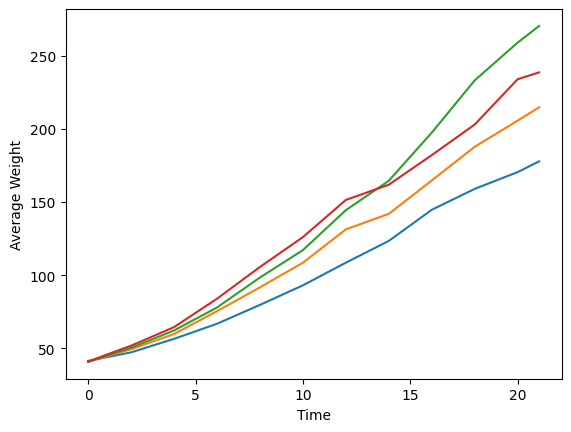

In [4]:
#2. Visualize mean weight over time as line graph

import seaborn as sb
import matplotlib.pyplot as plt

plt.xlabel('Time')
plt.ylabel('Average Weight')
for i in range(1, 5):
    sb.lineplot(data = avgs_summary, x = avgs_summary['index'], y = avgs_summary[i])

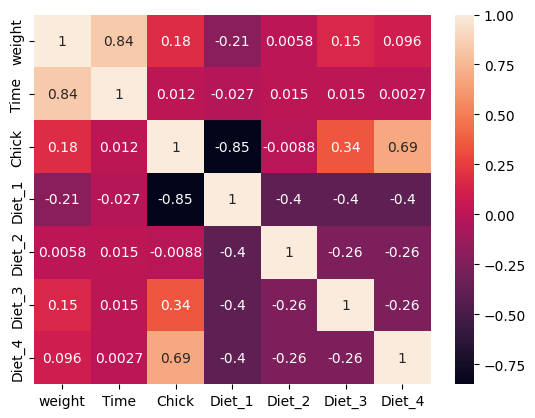

In [5]:
#3. Create a correlation heatmap of the numeric variables; include diet as dummy variables.

dummies = pd.get_dummies(chickweight, columns = ['Diet'], drop_first = False) #Drop to consider all the diets instead of using one as a "reference class"
corr_matrix = dummies.corr()

sb.heatmap(corr_matrix, annot = True)
plt.title = ("Correlation Heatmap")


In [26]:
#4. Write a function to calculate the slope coefficient for each diet
from sklearn.linear_model import LinearRegression
import numpy as np

def dietslope_calc(df):
    slopes = {}
    
    for diet in df['Diet']: #Loop through all diet types similar to before
        diet_entries = df[df['Diet'] == diet]
        
        X = diet_entries['Time'].values.reshape(-1, 1)
        y = diet_entries['weight'].values.reshape(-1, 1)
        
        model = LinearRegression()
        model.fit(X, y)
        
        slopes[diet] = model.coef_[0][0] #Store
        
    return slopes

dietslope_calc(chickweight) 

{1: 6.841797198382129,
 2: 8.609136288004839,
 3: 11.422870972621386,
 4: 9.714365562015416}

In [7]:
#5.	Write a function that calculates residual sum of squares (RSS), and then compare the minimal value to find the optimal slopes for each parameter and parameter combination

def get_rss(true, predicted):
    return np.sum((true - predicted) ** 2)

from sklearn.linear_model import LinearRegression

rss_perdiet = {}
for diet in chickweight['Diet'].unique(): #Loop through all diet types, again similar to before
        diet_entries = chickweight[chickweight['Diet'] == diet]
        
        X = diet_entries['Time'].values.reshape(-1, 1) 
        y = diet_entries['weight'].values.reshape(-1, 1)
        
        model = LinearRegression()
        model.fit(X, y)
        pred = model.predict(X)
        
        rss = get_rss(y, pred)
        rss_perdiet[diet] = rss

print(rss_perdiet)

{1: 235211.53211635142, 2: 201864.2068068371, 3: 172400.71825744968, 4: 52055.57537250331}


In [8]:
#Diet 4 has the minimal RSS, so it has the optimal slopes

#6. Use ANOVA function to determine if the RSS are significant (compare the F statistic)
from scipy.stats import f_oneway

diet_weights = []
for diet in chickweight['Diet'].unique(): 
    weights = chickweight[chickweight['Diet'] == diet]['weight'].values #Get all weights from where the diet is the one we are looping through
    diet_weights.append(weights)
    
f_stat, p_val = f_oneway(*diet_weights) #I looked up "Python equivalent of ANOVA function"

print("F-statistic:", f_stat)
print("P-value:", p_val)

#High F-statistic and low P-value indicates significant difference between the diets

F-statistic: 10.810089746832153
P-value: 6.433247186683061e-07


In [9]:
#7. Use backwards selection to find the best model

import statsmodels.formula.api as smf
model1 = smf.ols('weight ~ 0 + Time + Diet_1 + Diet_2 + Diet_3 + Diet_4', data = dummies.astype(int)).fit() #It kept summarizing outcomes of Booleans so I had to convert the dummies to int
print(model1.pvalues)

Time      1.803038e-165
Diet_1     1.218886e-03
Diet_2     7.418376e-11
Diet_3     3.595277e-28
Diet_4     4.116781e-22
dtype: float64


In [10]:
#Least significant is Diet 1. They are already all below 0.05 so I will just keep trying until the p values are as minimized as possible.
model2 = smf.ols('weight ~ 0 + Time + Diet_2 + Diet_3 + Diet_4', data = dummies.astype(int)).fit()
print(model2.pvalues)

Time      1.573758e-239
Diet_2     1.314648e-08
Diet_3     2.059311e-26
Diet_4     5.348308e-20
dtype: float64


In [11]:
#Least significant: Diet 2
model3 = smf.ols('weight ~ 0 + Time + Diet_3 + Diet_4', data = dummies.astype(int)).fit()
print(model3.pvalues)

Time      6.929728e-271
Diet_3     2.099005e-21
Diet_4     1.264586e-15
dtype: float64


In [12]:
#Least significant: Diet 4.
#This is confusing because according to the RSS Diet 4 should be the best predictor, but according to this and the-
#- correlation heatmap Diet 3 is the best.

#8. Now to backwards select until the f statistic is insignificant
print("Model 1 F stat:", model1.fvalue, "P value:", model1.f_pvalue)

Model 1 F stat: 419.1773497434213 P value: 1.4406690478461274e-168


In [13]:
#Still significant, continue
print("Model 2 F stat:", model2.fvalue, "P value:", model2.f_pvalue)

Model 2 F stat: 2037.7598646542733 P value: 0.0


In [14]:
#Still significant, continue
print("Model 3 F stat:", model3.fvalue, "P value:", model3.f_pvalue)

Model 3 F stat: 2562.1507152035388 P value: 0.0


In [15]:
#Still significant, make a new model with Diet 4 removed and continue since I only got up to 3 models for the last question
model4 = smf.ols('weight ~ 0 + Time + Diet_3', data = dummies.astype(int)).fit()
print("Model 4 F stat:", model4.fvalue, "P value:", model4.f_pvalue)

Model 4 F stat: 3413.900340927995 P value: 3.9693e-320


In [16]:
#Still significant...
model5 = smf.ols('weight ~ 0 + Time', data = dummies.astype(int)).fit()
print("Model 5 F stat:", model5.fvalue, "P value:", model5.f_pvalue)

Model 5 F stat: 6079.6570163540255 P value: 1.350813481981019e-308


In [17]:
#At this point, I am just assuming that the time predictor is so strong that even reducing it down to just that one-
#-keeps the model significant.

#9. Create a quadratic model to see if it's better than the linear one
dummies['Time^2'] = dummies['Time'] ** 2
model_q = smf.ols('weight ~ 0 + Time + Time^2', data = dummies.astype(int)).fit()

#Model 5 is already just linear weight and time, so I am just going to compare it to that.
rss_lin = sum(model5.resid ** 2)
rss_q = sum(model_q.resid ** 2)

print("Linear RSS:", rss_lin, "Quadratic RSS:", rss_q)

Linear RSS: 996120.1730402254 Quadratic RSS: 993712.8711845833


In [18]:
#It seems like the linear is slightly better.

#10. Create a null model
null = smf.ols('weight ~ 1', data = chickweight).fit()
summary_null = null.summary()
print(summary_null)

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 19 Sep 2025   Prob (F-statistic):                nan
Time:                        23:57:55   Log-Likelihood:                -3284.1
No. Observations:                 578   AIC:                             6570.
Df Residuals:                     577   BIC:                             6574.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    121.8183      2.956     41.208      0.0